# Proof of concept: Comparison of the CENTRE and CENTRE.MSI.MI classifiers in GM12878.RNAPII-ChIAPET dataset

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from xgboost import plot_importance
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
#from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from numpy import sort

In [2]:
targetfinder_df = pd.read_csv('/project/CRUP_scores/toSara/BENGI_processed_datasets/GM12878.RNAPII-ChIAPET-Benchmark.v38.txt', header=0, sep='\t')
print (targetfinder_df.shape)
targetfinder_df.head()

(116429, 36)


,gene_id1,gene_id,symbol38,symbol19,pair,pair19,label,CV,EP_prob_enh.1,EP_prob_enh.2,...,PP_prob_gene.4,PP_prob_gene.5,distance,cor_CRUP,combined_tests,reg_dist_enh,norm_reg_dist_enh,reg_dist_prom,norm_reg_dist_prom,RNA_seq
0,ENSG00000000457,ENSG00000000457.9,EH38E1396208,EH37E0122147,EH38E1396208_ENSG00000000457,EH37E0122147_ENSG00000000457.9,0,cv-11,0.3626,0.410,...,0.4128,0.4650,199381.0,0.043343,6.168070,75.0,0.037613,15.0,0.007523,1.870
1,ENSG00000000938,ENSG00000000938.8,EH38E2798012,EH37E0078610,EH38E2798012_ENSG00000000938,EH37E0078610_ENSG00000000938.8,0,cv-11,0.9604,0.882,...,0.0350,0.0055,4214.0,0.682945,26.538219,43.0,1.000000,0.0,0.000000,18.255
2,ENSG00000000938,ENSG00000000938.8,EH38E1331528,EH37E0078516,EH38E1331528_ENSG00000000938,EH37E0078516_ENSG00000000938.8,0,cv-11,0.4731,0.639,...,0.0350,0.0055,78982.0,0.473279,20.376245,135.0,0.170886,0.0,0.000000,18.255
3,ENSG00000000938,ENSG00000000938.8,EH38E2798072,EH37E0078640,EH38E2798072_ENSG00000000938,EH37E0078640_ENSG00000000938.8,0,cv-11,0.6138,0.882,...,0.0350,0.0055,54694.0,-0.036306,0.601604,85.0,0.155109,0.0,0.000000,18.255
4,ENSG00000000938,ENSG00000000938.8,EH38E1331661,EH37E0078612,EH38E1331661_ENSG00000000938,EH37E0078612_ENSG00000000938.8,0,cv-11,0.9700,0.980,...,0.0350,0.0055,3130.0,0.664666,39.350448,32.0,1.000000,0.0,0.000000,18.255


In [3]:
xgbost_df = pd.read_csv("/project/CRUP_scores/CENTRE_HiC/Training/BENGI_MSI_MI_datasets/GM12878.RNAPII-ChIAPET-Benchmark.MI.MSI.v38.csv", 
                 header=0, sep=',')
print (xgbost_df.shape)
xgbost_df.head()

(116429, 38)


,pair,gene_id1,gene_id,symbol38,symbol19,pair19,label,CV,EP_prob_enh.1,EP_prob_enh.2,...,distance,cor_CRUP,combined_tests,reg_dist_enh,norm_reg_dist_enh,reg_dist_prom,norm_reg_dist_prom,RNA_seq,min_insulation,mean_switch_intensity
0,EH38E0078724_ENSG00000009780,ENSG00000009780,ENSG00000009780.11,EH38E0078724,EH37E0078724,EH37E0078724_ENSG00000009780.11,0,cv-11,0.9504,0.8256,...,163735.0,-0.035565,7.276625,160.0,0.097680,17.0,0.010379,1.605,-4.492532,148.416031
1,EH38E0078724_ENSG00000117748,ENSG00000117748,ENSG00000117748.5,EH38E0078724,EH37E0078724,EH37E0078724_ENSG00000117748.5,0,cv-11,0.9504,0.8256,...,24880.0,0.140980,23.980109,39.0,0.156000,8.0,0.032000,19.105,-3.101508,14.773441
2,EH38E0078724_ENSG00000117751,ENSG00000117751,ENSG00000117751.13,EH38E0078724,EH37E0078724,EH37E0078724_ENSG00000117751.13,0,cv-11,0.9504,0.8256,...,58914.0,0.177648,6.704643,137.0,0.232203,8.0,0.013559,12.610,-4.492532,46.222313
3,EH38E0078724_ENSG00000117758,ENSG00000117758,ENSG00000117758.9,EH38E0078724,EH37E0078724,EH37E0078724_ENSG00000117758.9,0,cv-11,0.9504,0.8256,...,116477.0,0.124816,3.474906,151.0,0.129614,13.0,0.011159,5.650,-4.492532,36.901888
4,EH38E0078724_ENSG00000130768,ENSG00000130768,ENSG00000130768.10,EH38E0078724,EH37E0078724,EH37E0078724_ENSG00000130768.10,0,cv-11,0.9504,0.8256,...,45304.0,0.084059,4.869511,40.0,0.088106,9.0,0.019824,0.380,-3.101508,48.070886


In [4]:
xgbost_df['label'].value_counts()[0]/xgbost_df['label'].value_counts()[1]

6.327648058405186

In [5]:
com=xgbost_df.fillna(0)
com1=targetfinder_df.fillna(0)

In [9]:
def optimalparamsearch(com):
    cv_names=com["CV"].unique()
    myCViterator = []
    for i in range(len(cv_names)):
        trainIndices = com[ com['CV']!=cv_names[i] ].index.values.astype(int)
        testIndices =  com[ com['CV']==cv_names[i] ].index.values.astype(int)
        myCViterator.append( (trainIndices, testIndices) )


    #run randomized search for optimal parameters

    X_train= com.drop(['gene_id1','gene_id','symbol38','symbol19','pair','pair19','label','CV'], axis=1).copy()
    y_train = com['label'].copy()
    model = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0)
    param_grid = {
            'max_depth': [4, 5, 6,8,10,12],
            'learning_rate': [0.1, 0.05, 0.01],
            'gamma': [0, 0.25, 1.0],
            'reg_lambda': [0, 1.0, 10.0],
            'n_estimators': [100,200,300,400,500],
            'colsample_bytree': [0.5,0.6,0.7,0.9],
            'subsample': [0.7, 0.9]
        }
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,scoring='f1', cv=myCViterator, n_jobs=12, refit=True)
    result = search.fit(X_train, y_train)
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    return(result.best_score_, result.best_params_)
    

In [10]:
com['distance'] =com['distance'].abs()
com=com.sort_values('pair19')
com=com.reset_index(drop=True)

(best_score, best_params) = optimalparamsearch(com)

est=0.636, cfg={'subsample': 0.7, 'reg_lambda': 10.0, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 0.7}


In [11]:
#Optimal parameter search for CENTRE
com1['distance'] =com1['distance'].abs()
com1=com1.sort_values('pair19')
com1=com1.reset_index(drop=True)

(best_score1, best_params1) = optimalparamsearch(com1)

/pkg/python-3.10.10-1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


est=0.638, cfg={'subsample': 0.7, 'reg_lambda': 10.0, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}


In [14]:
### Train CENTRE with optimized params
X_train_tf= com1.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
y_train_tf = com1['label'].copy()
clf_tf = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params1)
clf_tf.fit(X_train_tf, y_train_tf)
list(X_train_tf.columns)

['EP_prob_enh.1',
 'EP_prob_enh.2',
 'EP_prob_enh.3',
 'EP_prob_enh.4',
 'EP_prob_enh.5',
 'EP_prob_gene.1',
 'EP_prob_gene.2',
 'EP_prob_gene.3',
 'EP_prob_gene.4',
 'EP_prob_gene.5',
 'PP_prob_enh.1',
 'PP_prob_enh.2',
 'PP_prob_enh.3',
 'PP_prob_enh.4',
 'PP_prob_enh.5',
 'PP_prob_gene.1',
 'PP_prob_gene.2',
 'PP_prob_gene.3',
 'PP_prob_gene.4',
 'PP_prob_gene.5',
 'distance',
 'cor_CRUP',
 'combined_tests',
 'reg_dist_enh',
 'norm_reg_dist_enh',
 'reg_dist_prom',
 'norm_reg_dist_prom',
 'RNA_seq']

In [15]:
#Train CENTRE.MI.MSI
X_train_xg= com.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
y_train_xg = com['label'].copy()
clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
clf_xgb.fit(X_train_xg, y_train_xg)
list(X_train_xg.columns)

['EP_prob_enh.1',
 'EP_prob_enh.2',
 'EP_prob_enh.3',
 'EP_prob_enh.4',
 'EP_prob_enh.5',
 'EP_prob_gene.1',
 'EP_prob_gene.2',
 'EP_prob_gene.3',
 'EP_prob_gene.4',
 'EP_prob_gene.5',
 'PP_prob_enh.1',
 'PP_prob_enh.2',
 'PP_prob_enh.3',
 'PP_prob_enh.4',
 'PP_prob_enh.5',
 'PP_prob_gene.1',
 'PP_prob_gene.2',
 'PP_prob_gene.3',
 'PP_prob_gene.4',
 'PP_prob_gene.5',
 'distance',
 'cor_CRUP',
 'combined_tests',
 'reg_dist_enh',
 'norm_reg_dist_enh',
 'reg_dist_prom',
 'norm_reg_dist_prom',
 'RNA_seq',
 'min_insulation',
 'mean_switch_intensity']

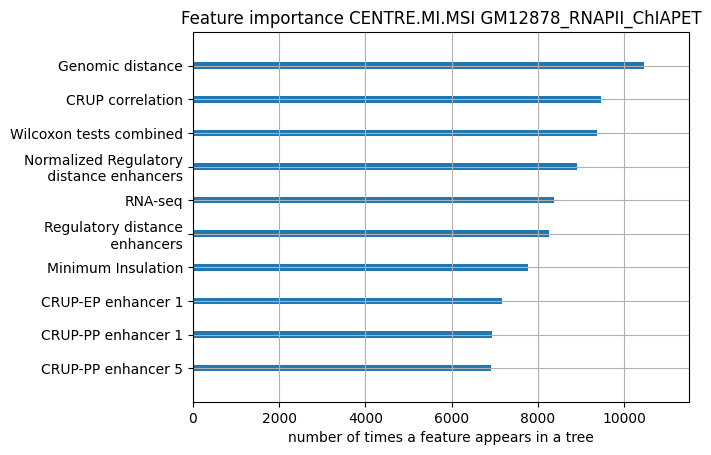

In [20]:
clf_xgb.get_booster().feature_names= ["CRUP-EP enhancer 1", "CRUP-EP enhancer 2", "CRUP-EP enhancer 3", "CRUP-EP enhancer 4",
                                     "CRUP-EP enhancer 5","CRUP-EP promoter 1","CRUP-EP promoter 2","CRUP-EP promoter 3",
                                     "CRUP-EP promoter 4","CRUP-EP promoter 5","CRUP-PP enhancer 1", "CRUP-PP enhancer 2", 
                                      "CRUP-PP enhancer 3", "CRUP-PP enhancer 4",
                                     "CRUP-PP enhancer 5","CRUP-PP promoter 1","CRUP-PP promoter 2","CRUP-PP promoter 3",
                                     "CRUP-PP promoter 4","CRUP-PP promoter 5","Genomic distance","CRUP correlation",
                                     "Wilcoxon tests combined","Regulatory distance\n enhancers",
                                      "Normalized Regulatory\n distance enhancers","Regulatory distance\n promoters",
                                      "Normalized Regulatory\n distance promoters", "RNA-seq", "Minimum Insulation", "Mean Switch Intensity"]

fig1=plot_importance(clf_xgb,xlabel="number of times a feature appears in a tree",show_values=False,
                     title= "Feature importance CENTRE.MI.MSI GM12878_RNAPII_ChIAPET",ylabel=None,max_num_features=10)
pyplot.show()
fig1.figure.tight_layout()
fig1.figure.savefig('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/GM12878_RNAPII_ChIAPET_featureImpotance10kb.png', 
             dpi=300,orientation='landscape',format='png',facecolor='white')
#fig1.figure.tight_layout()
# fig1.figure.savefig('/home/rapakoul/classification/xgboost/statquest_xgboost_in_python/CENTRE_revision/fimportance_GM12878_RNAPII_ChIAPET_weight.tiff', 
#               dpi=300,orientation='landscape',format='png',facecolor='white')


# clf_xgb.save_model("/home/rapakoul/classification/xgboost/statquest_xgboost_in_python/CENTRE_models/GM12878_RNAPII_ChIAPET_model.json")


In [17]:
clf_xgb.save_model("/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/GM12878_RNAPII_ChIAPET_model10kb.txt")

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:53:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [18]:
cv_names=com["CV"].unique()
d = dict(tuple(com.groupby('CV')))
d1 = dict(tuple(com1.groupby('CV')))
result_all_xgboost={}
result_all_tf={}
for i in range(len(cv_names)):
    cv_test=cv_names[i]
    cv_train=[x for k,x in enumerate(cv_names) if k!=i]
    X_test_xg = d[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_test_xg = d[cv_test]['label'].copy()
    train_xg=pd.concat({k: d[k] for k in cv_train})
    X_train_xg= train_xg.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_train_xg = train_xg['label'].copy()
    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
    clf_xgb.fit(X_train_xg, y_train_xg)
    pred_s = clf_xgb.predict_proba(X_test_xg)
    lr_probs =pred_s[:, 1]
    yhat = clf_xgb.predict(X_test_xg)
    result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_xg})
    result_all_xgboost[cv_test]=result_cv
    X_test_tf = d1[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_test_tf = d1[cv_test]['label'].copy()
    train_tf=pd.concat({k: d1[k] for k in cv_train})
    X_train_tf= train_tf.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_train_tf = train_tf['label'].copy()
    clf_gb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params1)
    clf_gb.fit(X_train_tf, y_train_tf)
    pred_s = clf_gb.predict_proba(X_test_tf)
    lr_probs =pred_s[:, 1]
    yhat = clf_gb.predict(X_test_tf)
    result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_tf})
    result_all_tf[cv_test]=result_cv
    
    

results_xg=pd.concat(result_all_xgboost)
lr_precision_xg, lr_recall_xg, _ = precision_recall_curve(results_xg['true_label'], results_xg['pred_prob'])
lr_f1_xg, lr_auc_xg = f1_score(results_xg['true_label'], results_xg['pred_label']), auc(lr_recall_xg, lr_precision_xg)
print('xgboost HiC 12 fold CV: f1=%.3f auc=%.3f' % (lr_f1_xg, lr_auc_xg))


results_tf=pd.concat(result_all_tf)
lr_precision_tf, lr_recall_tf, _ = precision_recall_curve(results_tf['true_label'], results_tf['pred_prob'])
lr_f1_tf, lr_auc_tf = f1_score(results_tf['true_label'], results_tf['pred_label']), auc(lr_recall_tf, lr_precision_tf)
print('CENTRE 12 fold CV: f1=%.3f auc=%.3f' % (lr_f1_tf, lr_auc_tf))

dist_precision, dist_recall, _=precision_recall_curve(com['label'],1/abs(com['distance']))
dist_auc = auc(dist_recall, dist_precision)
print('Distance:auc=%.3f' % (dist_auc))

xgboost HiC 12 fold CV: f1=0.637 auc=0.696
CENTRE 12 fold CV: f1=0.634 auc=0.686
Distance:auc=0.339


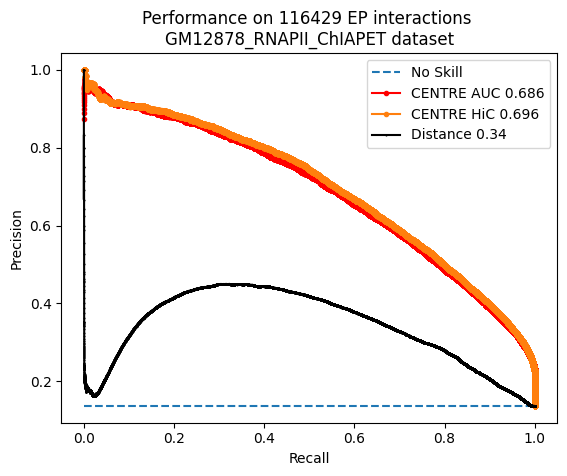

In [22]:
no_skill = sum(results_xg['true_label']) /len(results_xg.index)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_tf,lr_precision_tf, marker='.', label='CENTRE AUC 0.686',color='red')
pyplot.plot(lr_recall_xg, lr_precision_xg, marker='.', label='CENTRE HiC 0.696')
pyplot.plot(dist_recall,dist_precision, marker='.',color='black' ,label='Distance 0.34',markersize=1)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
#pyplot.text(0.4, 0.5, "AUC=0.70")
pyplot.title('Performance on 116429 EP interactions \nGM12878_RNAPII_ChIAPET dataset')
# show the legend
pyplot.legend()
# show the plot
fig1 =pyplot.gcf()
pyplot.show()
fig1.savefig('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/GM12878_RNAPII_ChIAPET_10kbperformance.png', 
             dpi=300,orientation='landscape',format='png',facecolor='white')